In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, 'models')
sys.path.insert(0, 'utils')
import celeba
import numpy as np
import wandb
import wandb
import matplotlib.pyplot as plt
import numpy as np
import torch
import argparse
from plotting_utils import plot_pytorch_images

from vae_model_upsample import UPSAMPLE_VAE, loss_function
from datasets import VAE_DATA

torch.manual_seed(0)
np.random.seed(0)

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--num_datapoints", help="num datapoints", default=100000, type=int)
parser.add_argument("--validation_size", help="Validation set size", default=20000, type=int)
parser.add_argument("--resolution", help="num datapoints", default=128, type=int)
parser.add_argument("--z_dim", help="z dimension", default=85, type=int)
parser.add_argument("--device", help="gpu id", default=1, type=int)
parser.add_argument("--nb_epochs", help="number of epochs", default=500, type=int)
parser.add_argument("--start_epoch", help="epoch to start training from (requires checkpoints)", default=0, type=int)
parser.add_argument("--save_interval", help="epochs to save model", default=10, type=int)
parser.add_argument("--run_seed", help="run seed of TCVAE", default=100, type=int)
parser.add_argument("--lr", help="learning rate", default=.0001, type=float)
parser.add_argument("--batch_size", help="batch size", default=100, type=int)
parser.add_argument("--has_validation", help="If True, will use validation set", default=True, type=bool)
args = parser.parse_args([])

num_datapoints = args.num_datapoints
resolution = args.resolution

log = True
if log:
    wandb.init(project="upsample_vae", name="celeba_{}_{}x{}".format(num_datapoints, resolution, resolution))
    wandb.config.update(args)

device = args.device
print("z_dim: {}".format(args.z_dim))
print("GPU: {}".format(device))
print("start_epoch: {}".format(args.start_epoch))
print("save_interval: {}".format(args.save_interval))

wandb: Wandb version 0.8.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


z_dim: 85
GPU: 1
start_epoch: 0
save_interval: 10


# Preparing Data

In [3]:
validation_size = 0
if args.has_validation:
    validation_size = args.validation_size
num_samples = num_datapoints + validation_size
if resolution > 128:
    raise ValueError("Not that big")
dta = celeba.CelebA("../dsvae/yukun_disentanglement_lib/img_align_celeba", num_samples, resolution)
inputs = np.float32(dta.images[:num_datapoints])
torch_inputs = torch.from_numpy(inputs).permute(0,3,1,2)
torch_dataset = VAE_DATA(torch_inputs)
torch_data_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=args.batch_size, shuffle=True)

if args.has_validation:
    val_inputs = np.float32(dta.images[num_datapoints:])
    torch_val_inputs = torch.from_numpy(val_inputs).permute(0,3,1,2)
    torch_val_dataset = VAE_DATA(torch_val_inputs)
    torch_val_data_loader = torch.utils.data.DataLoader(torch_val_dataset, batch_size=args.batch_size, shuffle=False)
del dta

120000
finish reading face images
(120000, 128, 128, 3)


# Instantiating and Training VAE

In [ ]:
input_shape=[3,resolution,resolution]
upsample_from_shape = [3,64,64]
if device != -1 and device is not None:
    vae = UPSAMPLE_VAE(args.z_dim, input_shape, upsample_from_shape, device=device)
    vae.to(device)
else:
    vae = UPSAMPLE_VAE(args.z_dim, input_shape, upsample_from_shape, device=None)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=args.lr)

Training for 1500 epochs...


/root/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
wandb: Wandb version 0.8.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/root/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


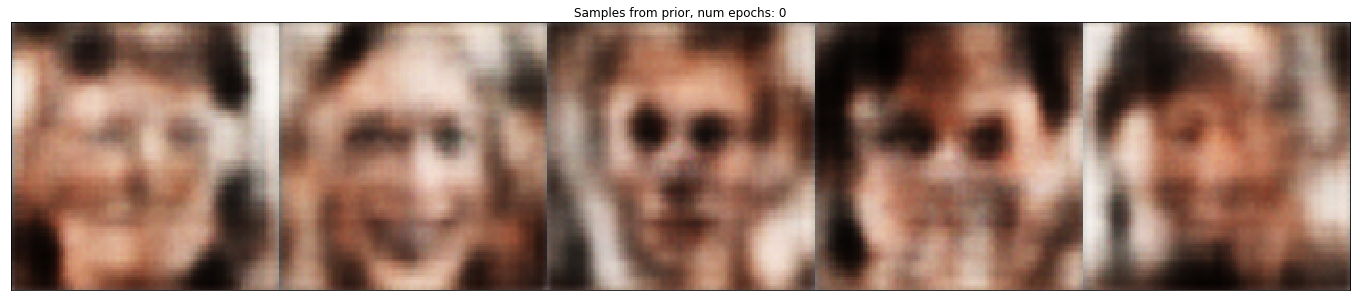

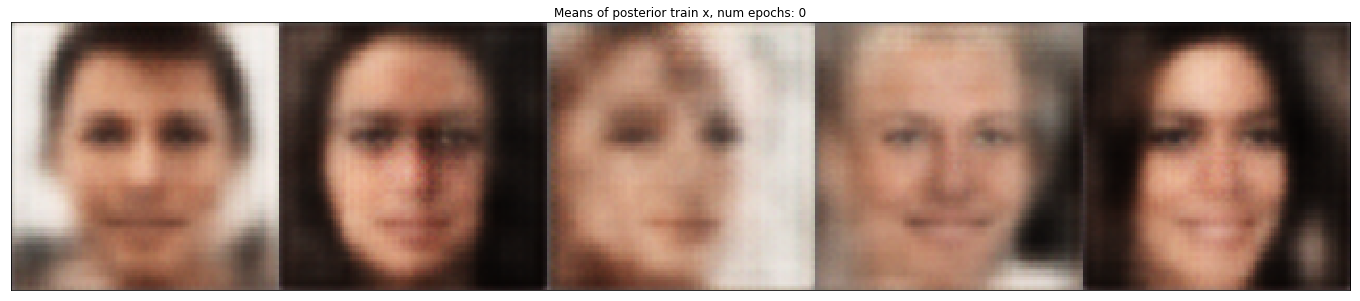

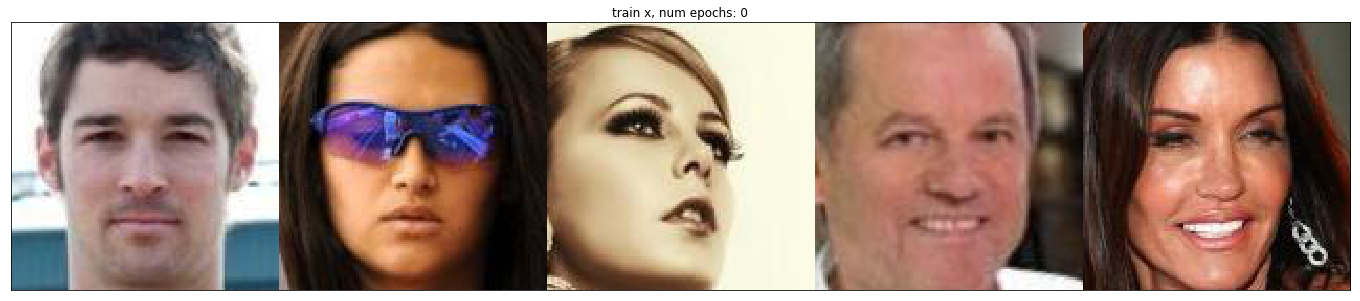

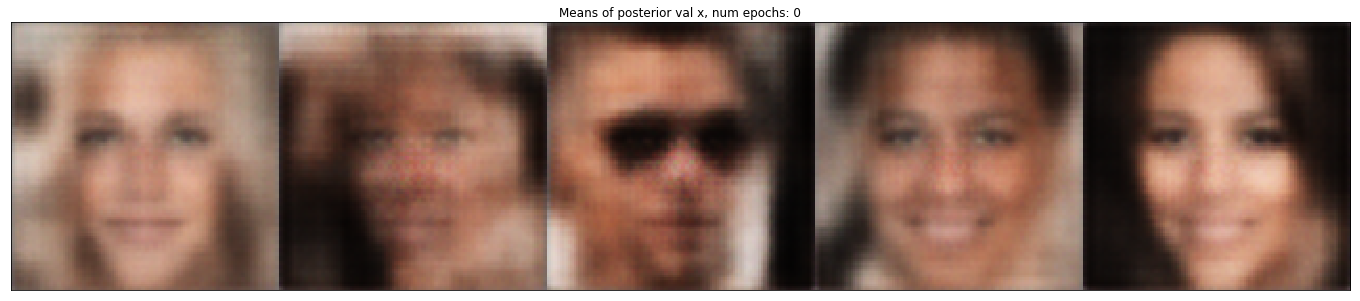

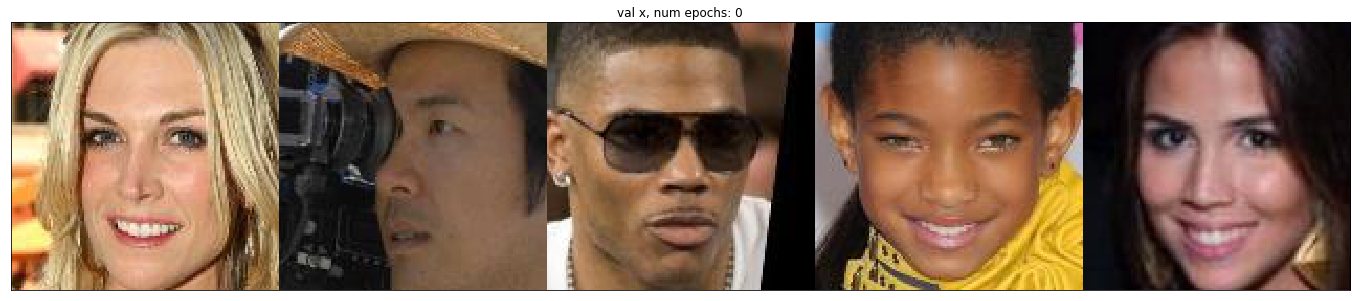

In [ ]:
vae.train()
normal = torch.distributions.Normal(0,1)
print("Training for {} epochs...".format(1500))
for n in range(0, 1500):
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    num_examples = 0
    for (i, X) in enumerate(torch_data_loader):
        x = X
        if vae.cuda:
            x = x.to(device)
        optimizer.zero_grad()
        x_hat, z_mu, z_var = vae(x)
        loss, recon_loss, kl_loss = loss_function(x_hat, x, z_mu, z_var)
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        num_examples += x_hat.shape[0]
        loss.backward()
        optimizer.step()
    if log:
        wandb.log({'train_loss':train_loss/num_examples})
        wandb.log({'train_recon_loss':train_recon_loss/num_examples})
        wandb.log({'train_kl_loss':train_kl_loss/num_examples})
        
    if args.has_validation:
        vae.eval()
        val_loss = 0
        val_recon_loss = 0
        val_kl_loss = 0
        num_examples = 0
        for (i, X) in enumerate(torch_val_data_loader):
            x_val = X
            if vae.cuda:
                x_val = x_val.to(device)
            x_hat_val, z_mu, z_var = vae(x_val)
            loss, recon_loss, kl_loss = loss_function(x_hat_val, x_val, z_mu, z_var)
            val_loss += loss.item()
            val_recon_loss += recon_loss.item()
            val_kl_loss += kl_loss.item()
            num_examples += x_hat_val.shape[0]
        if log:
            wandb.log({'val_loss':val_loss/num_examples})
            wandb.log({'val_recon_loss':val_recon_loss/num_examples})
            wandb.log({'val_kl_loss':val_kl_loss/num_examples})
        vae.train()
        
    if n%10 ==0:
        vae.eval() #evaluate model
        z_noise = normal.sample((x.shape[0],85))
        z_zeros = torch.zeros((x.shape[0],85))
        if vae.cuda:
            z_noise = z_noise.to(device)
            z_zeros = z_zeros.to(device)
        x_hat_noise = vae.decode(z_noise)
        x_hat_zeros = vae.decode(z_zeros)

        fig = plot_pytorch_images(x_hat_noise[:5], num_images=5, title='Samples from prior, num epochs: {}'.format(n))
        if log:
            wandb.log({'Samples from prior':fig})
            
        fig = plot_pytorch_images(x_hat[:5], num_images=5, title='Means of posterior train x, num epochs: {}'.format(n))
        if log:
            wandb.log({'Means of posterior train x':fig})
            
        fig = plot_pytorch_images(x[:5], num_images=5, title='train x, num epochs: {}'.format(n))
        if log:
            wandb.log({'train x':fig})
        
        if args.has_validation:
            x_val = torch_val_dataset[np.random.choice(range(len(torch_val_dataset)), size=5, replace=False)]
            if vae.cuda:
                x_val = x_val.to(device)
            x_val_hat, _, _ = vae(x_val)
            fig = plot_pytorch_images(x_val_hat[:5], num_images=5, title='Means of posterior val x, num epochs: {}'.format(n))
            if log:
                wandb.log({'Means of posterior val x':fig})

            fig = plot_pytorch_images(x_val[:5], num_images=5, title='val x, num epochs: {}'.format(n))
            if log:
                wandb.log({'val x':fig})

        vae.train() #back to training model

In [ ]:
torch.save(vae, "UPVAE_10K_128")